# <b>What time windows are most likely to have large numbers of simultaneous players?

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


<b> INTRODUCTION

As a team, we are attempting to answer the question, "What time windows are most likely to have large numbers of simultaneous players," in order to understand peak times and ensure that licenses are available to accommodate peak usage. We chose the session.csv file to analyze individual player sessions on a Minecraft research server to understand usage patterns and peak demand times, as this is the file that has relevant information such as player start and end times. After reading the spreadsheet file, we can see 1535 rows and five columns representing the variables: hashed_email, start_time, end_time, original_start_time, and original_end_time, bringing the total number of observations to 7675. The data was likely collected through server logs that record player activities on the Plaicraft research server. Each entry represents an individual session, capturing start and end times for each play instance.


<b> POTENTIAL ISSUES:

- The end_time and original_end_time are missing 2 observations each on rows 681 and 1019. To determine high activity periods, accurate session durations are necessary. The presence of missing end times may impact these calculations.

- There may be inconsistencies in the time zone for each session, depending on the player’s location. Standardizing time zones to PST may be useful.

- Internet reliability: sessions where disconnections or reconnections impact the recorded start and end times.

See below for vector summaries following chapter 3.3.2 in the Textbook (Campbell et al., 2022):

In [1]:
df <- data.frame(
  Variable = c("hashedEmail", "start_time", "end_time", "original_start_time", "original_end_time"),
  Data_Type = c("Character", "Character", "Character", "Double", "Double"),
  Description = c(
    "Unique identifier for each player",
    "Start time of each session",
    "End time of each session",
    "Unix timestamp for start time",
    "Unix timestamp for end time"
  )
)
print(df)

             Variable Data_Type                       Description
1         hashedEmail Character Unique identifier for each player
2          start_time Character        Start time of each session
3            end_time Character          End time of each session
4 original_start_time    Double     Unix timestamp for start time
5   original_end_time    Double       Unix timestamp for end time


Using K-NN regression, we are attempting to find the time window that has the most amount of players, which we would then classify as a 'peak' time. We chose regression over classification as we are attempting to predict a *numerical* value (# of players) as opposed to a categorical one. This is because the number of players, which would be our response variable is a quantitative value. 

<b> METHODS & RESULTS

<b> 1. Loading the Data

The first step in the analysis was loading the dataset. This dataset contains time-stamped information about players initiating a session, and the total number of players during these periods. Proper loading ensures that the raw data is accessible for cleaning and analysis.
The dataset was examined to understand its structure, identify relevant columns (e.g., timestamps, player counts), and ensure it was ready for processing.

<b> 2. Data Wrangling

Before analysis, the data set was cleaned and wrangled to adress the aforementioned issues in the introduction:

- Handling Missing Data: Any missing values were addressed. Rows with incomplete data were either removed or filled with appropriate estimations, ensuring the analysis was not skewed by gaps in the dataset.

- Converting Timestamps: The timestamp column was converted into a standardized date-time format where time was converted to minutes. This allowed us to extract specific components, such as the hour of the day, which was crucial for hourly activity analysis.

  
- Aggregating Data by Play Minutes: Player counts were grouped and summarized based on how long each session lasted. This aggregation helped in understanding trends in player activity throughout the day and is shown via the `start_time_min` and `end_time_min` columns.

The cleaned data set is seen as follows:

In [4]:
sessions <- read_csv("data/sessions.csv") |>
                  mutate(start_time = dmy_hm(start_time),
                  end_time = dmy_hm(end_time),
                  start_time_date = as.Date(start_time),
                  end_time_date = as.Date(end_time),
                  start_time_min = hour(start_time) * 60 + minute(start_time),
                  end_time_min = hour(end_time) * 60 + minute(end_time),
                  start_time = format(start_time, "%H:%M:%S"),
                  end_time = format(end_time , "%H:%M:%S"),
                  player = row_number())
           
sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time,start_time_date,end_time_date,start_time_min,end_time_min,player
<chr>,<chr>,<chr>,<dbl>,<dbl>,<date>,<date>,<dbl>,<dbl>,<int>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,18:12:00,18:24:00,1.71977e+12,1.71977e+12,2024-06-30,2024-06-30,1092,1104,1
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,23:33:00,23:46:00,1.71867e+12,1.71867e+12,2024-06-17,2024-06-17,1413,1426,2
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,17:34:00,17:57:00,1.72193e+12,1.72193e+12,2024-07-25,2024-07-25,1054,1077,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15:36:00,15:57:00,1.72218e+12,1.72218e+12,2024-07-28,2024-07-28,936,957,1533
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,06:15:00,06:22:00,1.72189e+12,1.72189e+12,2024-07-25,2024-07-25,375,382,1534
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,02:26:00,02:45:00,1.71617e+12,1.71617e+12,2024-05-20,2024-05-20,146,165,1535


<b> 3. Exploratory Data Analysis

Exploratory Data Analysis was performed to uncover trends, patterns, and anomalies in player activity. we wanted to get a cursory overview of the data and see at what times players were most likely to log onto the server. We visualized the data with a histogram to get a glance at the times players were most likely to start a session.  

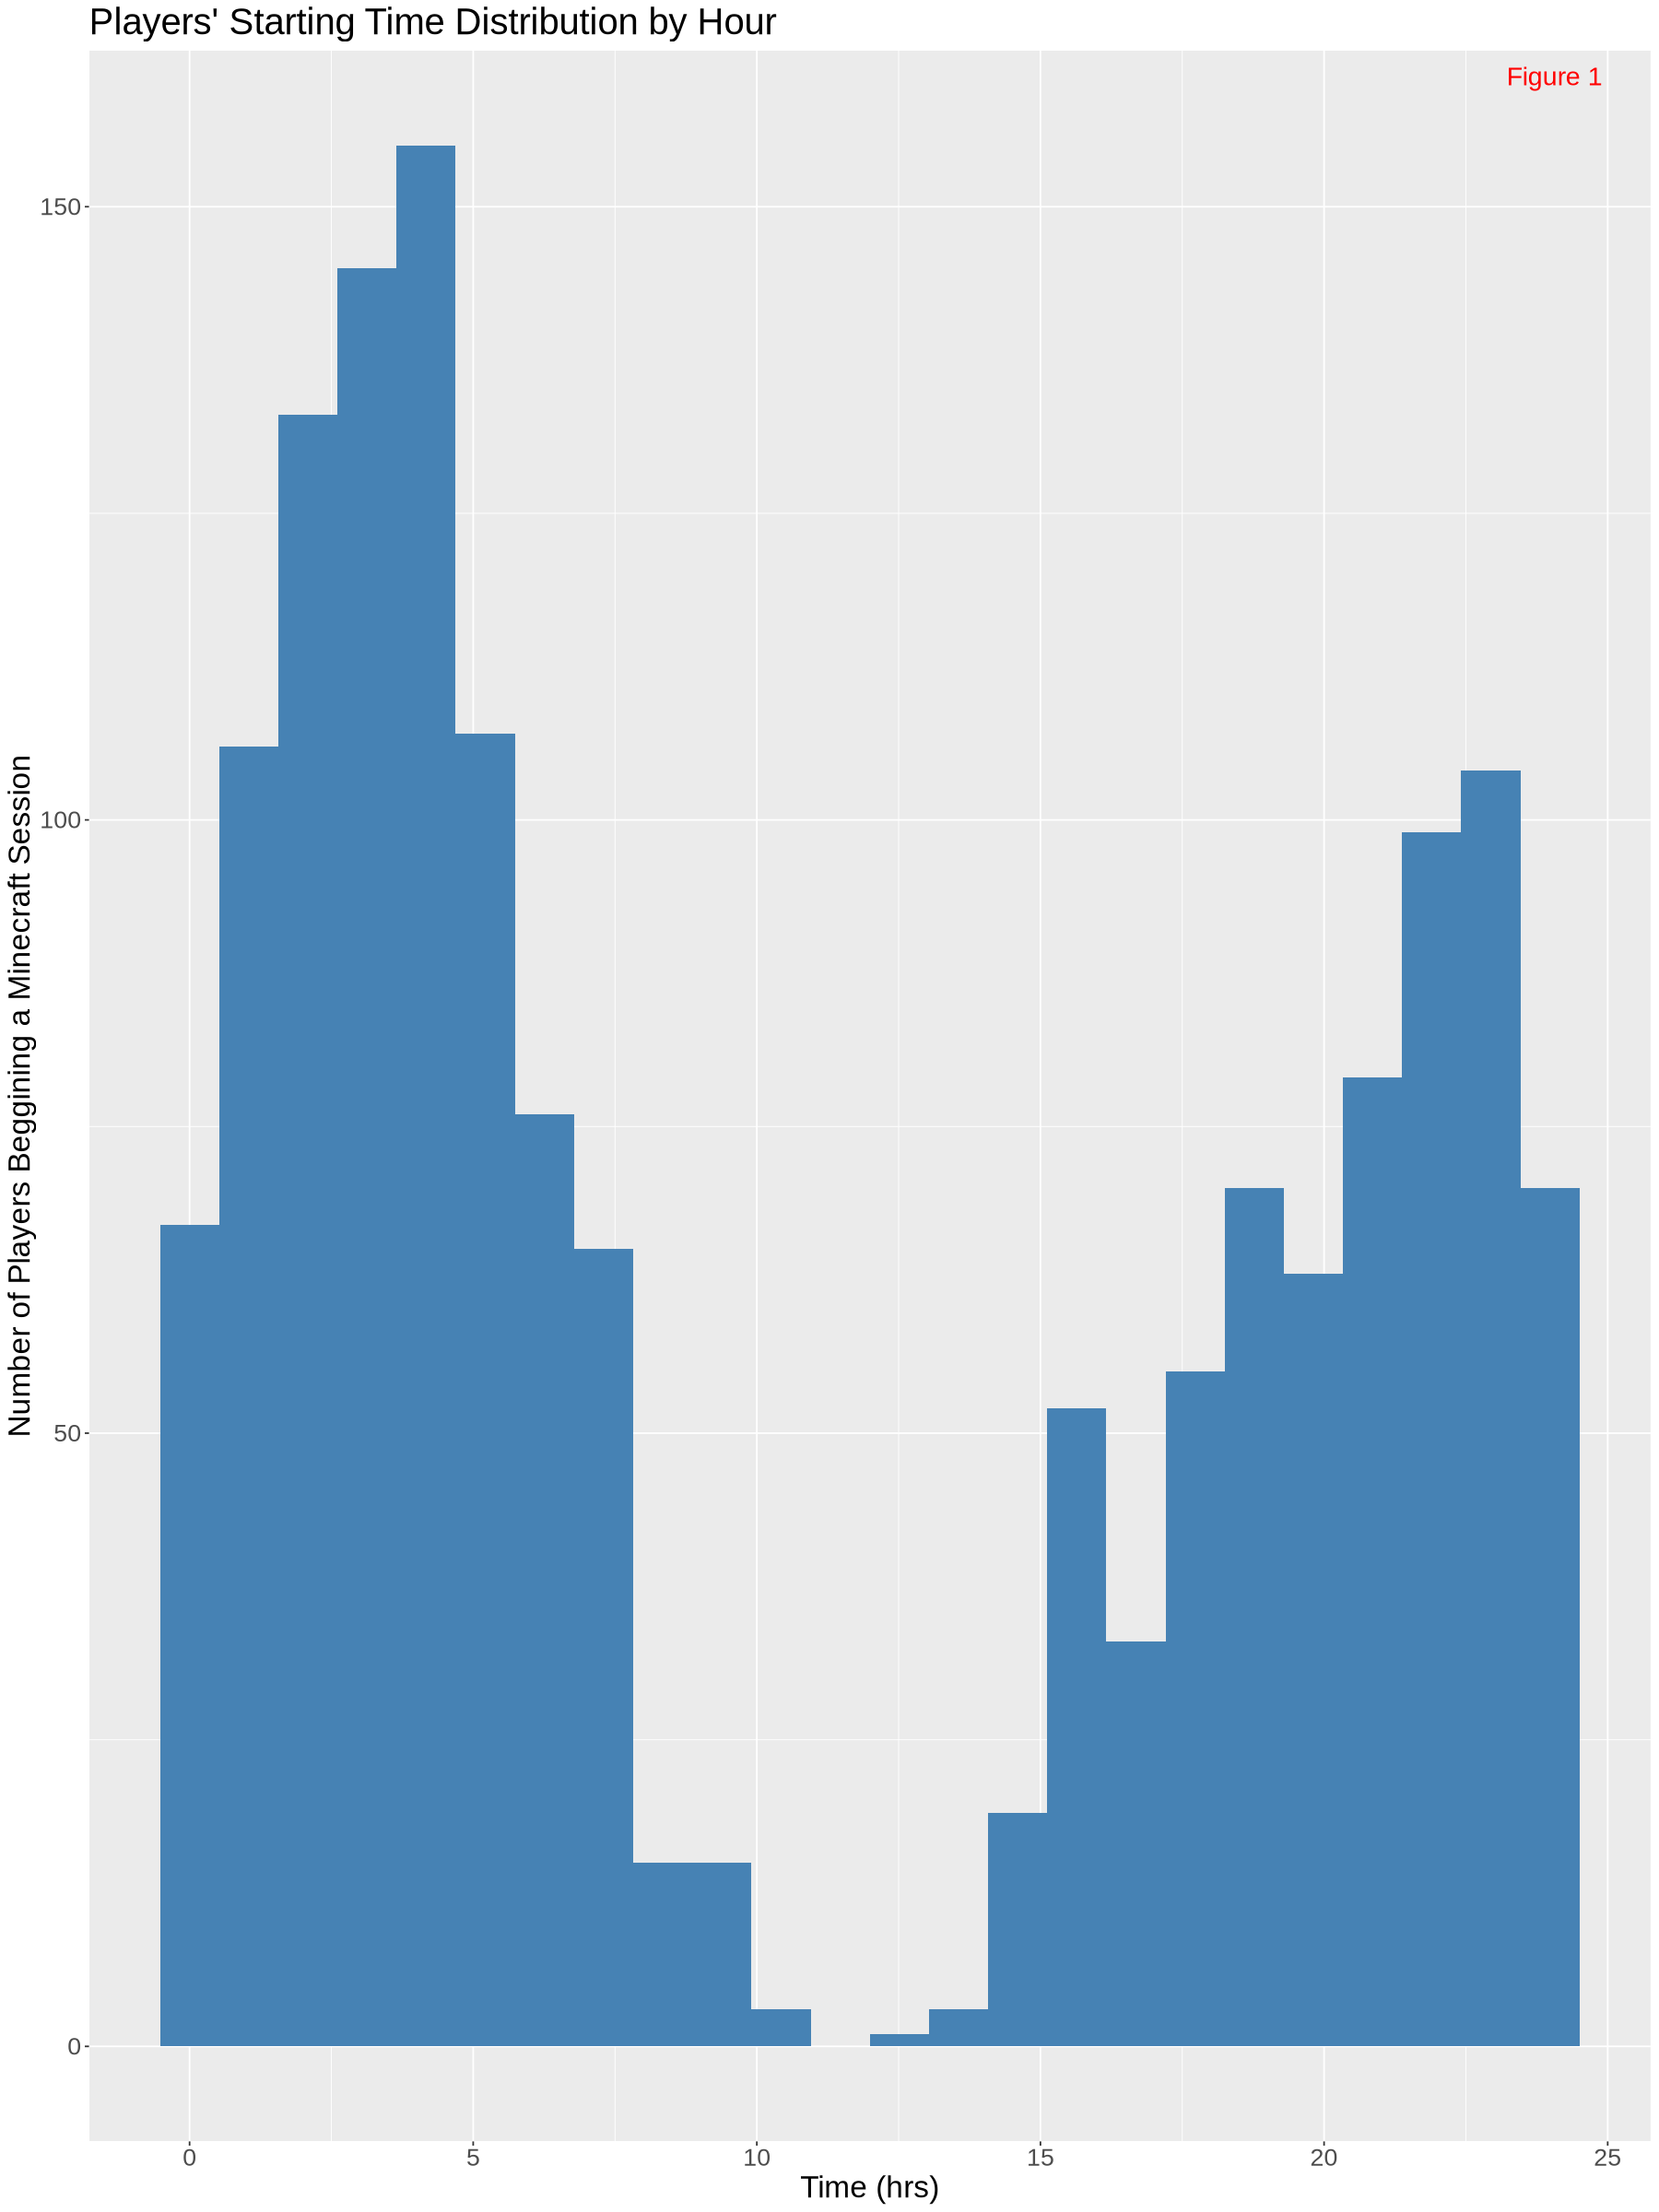

In [60]:
options(repr.plot.width = 15, repr.plot.height = 20)

start_time_distribution <- sessions |>
                 ggplot (aes ((x = start_time_min)/60)) +
                 geom_histogram(bins = 24, fill= "steelblue")+
                 labs(x = "Time (hrs)", y = "Number of Players Beggining a Minecraft Session",
                      title = "Players' Starting Time Distribution by Hour") +
                 theme(text = element_text (size = 20))

start_time_distribution + annotate("text", x=Inf, y=Inf, label="Figure 1", size=6, hjust=1.5, vjust=2, colour = "red")
                          

#start_time_distribution

Afterward, we broke down the play sessions and rounded them to 30-minute increments as players had relatively short play times (< 1 hour). We achieved this by mutating the `start_time_min` into 30-minute time slots. This effectively splits up a 24-hour period into 48, 30-minute slots. Afterwards, we grouped by the number of players who logged in within a specific slot and summarized that information into a 2 x 44 tibble with only two columns, `start_time_min` and `players`. In our K-NN regression model, `players` becomes our response variable as it is the variable we are trying to predict. The explanatory variable is the input on which we are basing our prediction, which in this case is the `start_time_min` variable as this is how we see when players log on and when there are likely to be more players.

Visualizations were then used to supplement these summaries:

**Line Graph:** The data was visualized as a line graph showing the number of players initiating sessions for each hour of the day. This highlighted patterns such as peaks during the evening and night and troughs during the day during typical class times (7:00 - 15:00).


start_time_min,players
<dbl>,<int>
0,30
1,66
2,58
⋮,⋮
46,56
47,59
48,29


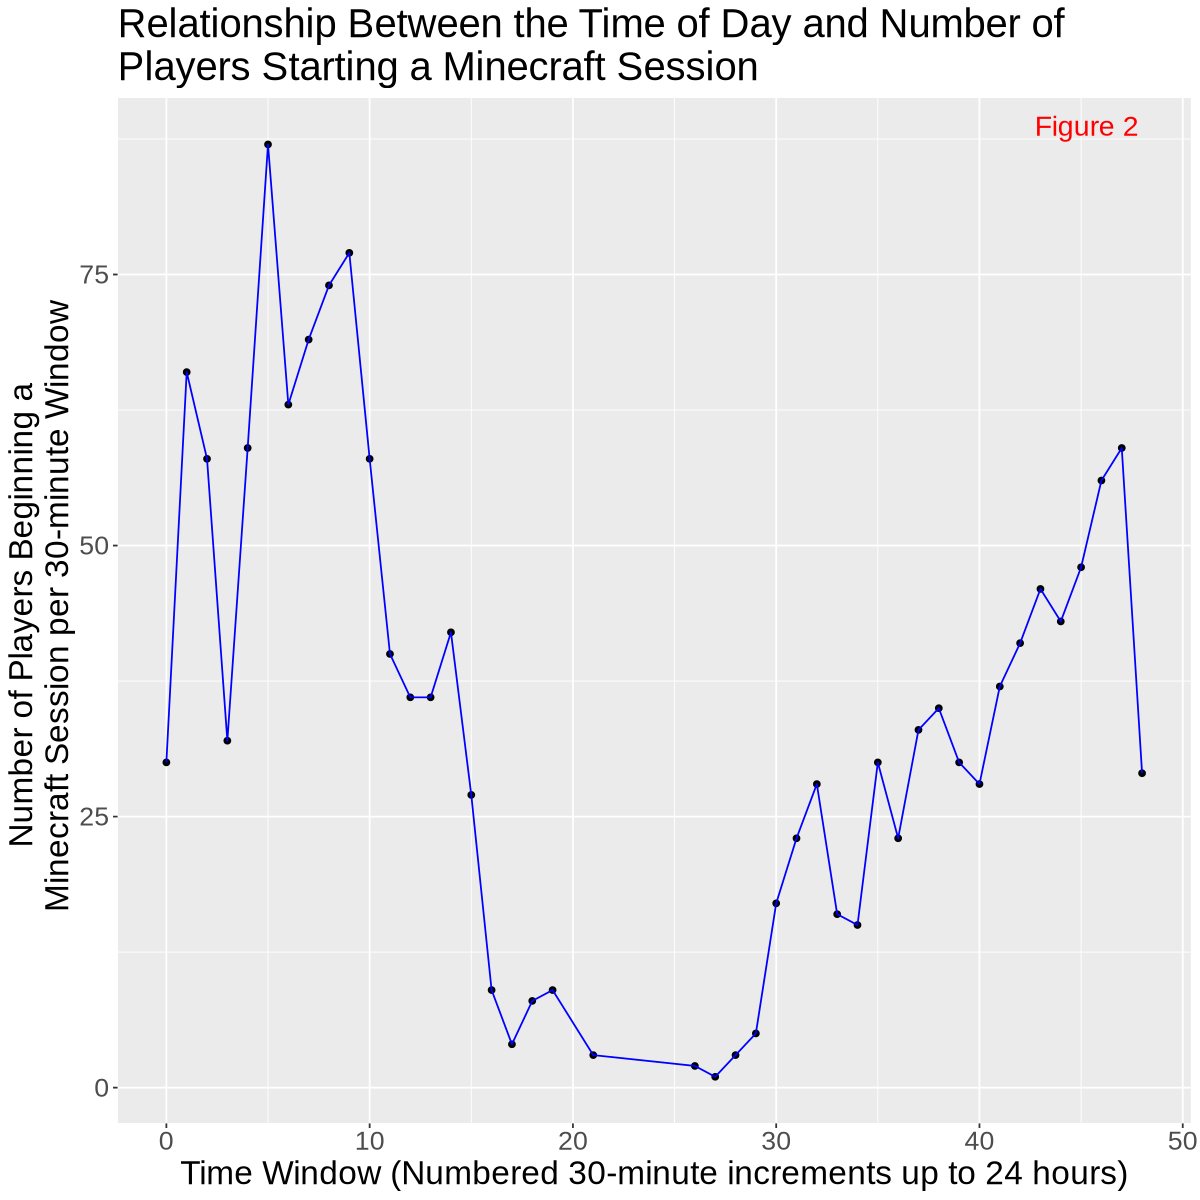

In [49]:
options(repr.plot.width = 10, repr.plot.height = 10)
sessions_peak_start <- sessions |>
                  mutate (start_time_min = round((start_time_min / 30), 0)) |>
                  group_by(start_time_min)|>
                  summarize(players = n())

sessions_peak_start

sessions_peak_start_plot <- sessions_peak_start |>
                     ggplot(aes(x = start_time_min , y = players))+
                     geom_point() +
                     geom_line(color = "blue") +
                     labs(x = "Time Window (Numbered 30-minute increments up to 24 hours)", y = "Number of Players Beginning a \n Minecraft Session per 30-minute Window",
                         title = "Relationship Between the Time of Day and Number of \nPlayers Starting a Minecraft Session") +
                     xlim(c(0, 48)) +  
                     theme(text = element_text (size = 20)) 
                      
sessions_peak_start_plot + annotate("text", x=Inf, y=Inf, label="Figure 2", size=6, hjust=1.5, vjust=2, colour = "red")

<b>4. Building our K-NN Regression Model

Firstly, we needed to split our `sessions_split` data set into our training and testing sets. After our model was built by specifying `players` as our response variable and `start_time_min` as our explanatory. We cross-validated our training set to determine the best K value that would minimize the RMSPE of our observations and find the best fitting for the number of neighbours. We did not explicitly set the seed as when R starts up, it will generate one on its own, which is sufficient for out model

In [14]:
sessions_split <- initial_split(sessions_peak_start, prop = 0.75, strata = start_time_min)
sessions_train <- training(sessions_split)
sessions_test <- testing(sessions_split)

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 2 breaks instead.”


In [15]:
sessions_recipe <- recipe(players ~ start_time_min, data = sessions_train) |>
                   step_scale(all_predictors()) |>
                    step_center(all_predictors())
sessions_recipe

sessions_spec <-  nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
                  set_engine("kknn") |>
                  set_mode("regression")
sessions_spec

sessions_vfold <- vfold_cv(sessions_train, v = 5, strata = players)

sessions_wkflw <-  workflow() |> 
                   add_recipe(sessions_recipe)|>
                   add_model(sessions_spec)

sessions_wkflw
              
                   



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 1



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 1 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [20]:
gridvals <- tibble(neighbors = seq(from = 1, to = 44))

sessions_results <- sessions_wkflw |>
                     tune_grid(resamples = sessions_vfold) |>
                     collect_metrics()|>
                     filter(.metric == "rmse")
sessions_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,rmse,standard,8.921184,5,1.507371,Preprocessor1_Model01
4,rmse,standard,10.507433,5,1.912528,Preprocessor1_Model02
5,rmse,standard,10.876099,5,1.663516,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,rmse,standard,18.11350,5,1.499570,Preprocessor1_Model08
13,rmse,standard,19.34563,5,1.708207,Preprocessor1_Model09
14,rmse,standard,19.96575,5,1.739690,Preprocessor1_Model10


In [21]:
sessions_min <-  sessions_results |>
                 filter(mean == min(mean))

sessions_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,rmse,standard,8.921184,5,1.507371,Preprocessor1_Model01


We determined the best K value to be K = 2 which is the value that will minimize the RMSPE between our observations. Using this K, we decided to build a new model and run it on our training set.

In [22]:
kmin <-  sessions_min |>
          pull(neighbors)

sessions_spec2 <-  nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
                   set_engine("kknn") |>
                   set_mode("regression")

sessions_spec2

sessions_fit <-  workflow() |>
                 add_recipe(sessions_recipe)|>
                 add_model(sessions_spec2) |>
                 fit(data = sessions_train)

sessions_fit   

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = kmin
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2L,     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 6.703125
Minimal mean squared error: 85.21094
Best kernel: rectangular
Best k: 2

<b> 5. Testing our Prediction

After building our model, it was now time to use it on our testing data and predict the number of players during a specific time slot. The resulting information was tabulate dinto a `tibble` vector and we can see our predictions in the `.pred` column. 

In [28]:
sessions_predictions <-  sessions_fit |>
                     predict(sessions_test)|>
                     bind_cols(sessions_test)
sessions_predictions
arranged_sessions_predictions <- arrange(sessions_predictions, by = desc(.pred))
arranged_sessions_predictions

sessions_summary <- sessions_predictions|>
                    metrics(truth = players, estimate =.pred) |>
                     filter(.metric == "rmse")
sessions_summary

.pred,start_time_min,players
<dbl>,<dbl>,<int>
49,0,30
49,2,58
61,5,87
⋮,⋮,⋮
19.0,33,16
41.5,42,41
57.5,48,29


.pred,start_time_min,players
<dbl>,<dbl>,<int>
73.0,8,74
61.0,5,87
57.5,48,29
⋮,⋮,⋮
19.0,33,16
9.0,28,3
8.5,21,3


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,13.90968


<b> 6. Visualizing Data

We constructed a scatterplot showing the time windows on the x-axis and players on the y-axis. Our regression model resulted in a line over our observations, showing the trends and predicted number of players for each respective time window. 

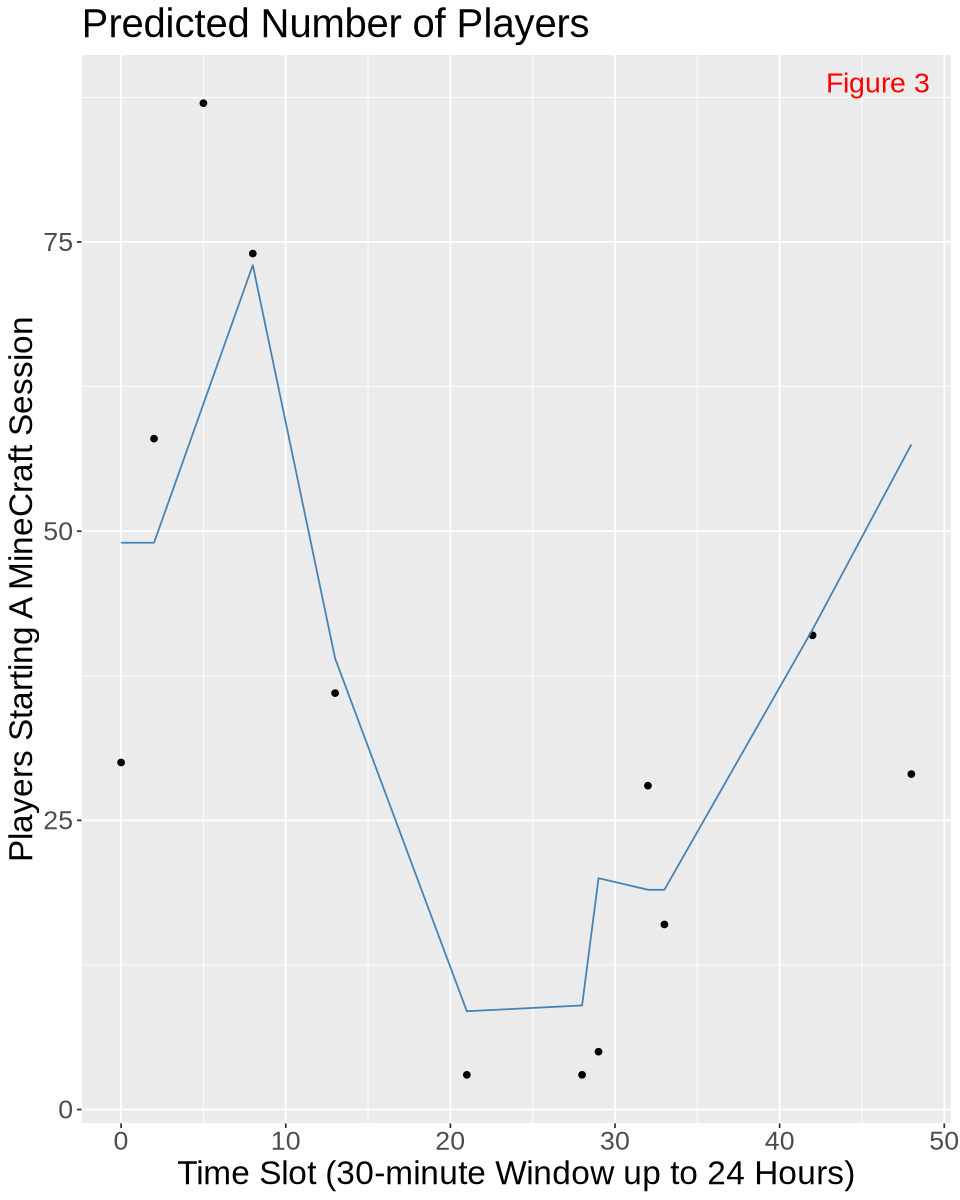

In [52]:
options(repr.plot.width = 8 , repr.plot.height = 10)
sessions_prediction_plot <-  sessions_predictions |>
                             ggplot(aes(x = start_time_min, y = players)) +
                             geom_point() +
                             geom_line(aes(x = start_time_min, y = .pred), 
                                      color = "steelblue") +
                             xlab("Time Slot (30-minute Window up to 24 Hours)") +
                             ylab("Players Starting A MineCraft Session") +
                             ggtitle("Predicted Number of Players") +
                             theme(text = element_text(size = 20))

sessions_prediction_plot + annotate("text", x=Inf, y=Inf, label="Figure 3", size=6, hjust=1.2, vjust=2, colour = "red")

<b> DISCUSSION & CONCLUSION

**1. Summary of Findings**

We can conclude from our model that since the time starts at midnight, and the highest point on the graph corresponds to the 8th, time window, if we convert this to hours, this is around 4:00 hours. This means that most players log onto the PLAICraft session at this time to start a session. As we continue analyzing the graph, we can see that the number of players continues to decline between 0400 - 1100 hours. The number of players stays the same between 1100 - 1330 hours. After we see an increase after, with a steep increase after 1500 hours. The number of players continues increasing up until midnight after which the cycle repeats, and we see a drop around 0400 hours once more. 

**2. Interpretation**

As a group, we were surprised by the findings as we expected more activity during the day when people were likelier to play with friends or to kill time between classes. The peaks and troughs suggest that player behaviour is influenced by external factors, such as breaks or scheduled events. After further analysis, we remembered that most PLAICraft users are fellow DSCI students or UBC students in general. Due to classes and other commitments, they are more likely to log in during the evening or at night. 

**3. Potential Impact**

Going back to our earlier question, this information is especially useful in many ways since we are interested in demand forecasting to ensure that there are enough licenses on hand to accommodate all players. We can determine how best to scale down during low-activity times to reduce costs and optimize resources. These insights could also support server capacity planning, preventing crashes during busy times, and guide the scheduling of events or promotions to maximize engagement. Over time, analyzing seasonal or geographic patterns can refine forecasts, ensuring long-term efficiency. Ultimately, these strategies improve player experience while balancing cost and operational demands.

**4. Errors and Areas for Improvement**

Our project could be further refined. For example, we could address potential issues regarding internet reliability. Having players kicked out of sessions or having them log in multiple times will affect our data and result in some inconsistent and incorrect observations. Furthermore, our model works based on start times when players first log into the server. Longer play duration may require more licenses or even idling players who disconnect and reconnect could also affect server load and capacity, resulting in overcounted and overestimated player predictions in our testing set, which is cost-inefficient and counterproductive. To prevent this, perhaps filtering `hashed_emails` for double counts or instances where players have logged in twice under the span of 5 minutes will help us refine our data and ensure that only the relevant information is used to train our model. 

<b> REFERENCES
1. Trevor Campbell, Melissa Lee, and Tiffany Timbers. "3.3.2 What is a Vector?" *Data Science: A First Introduction*, 2022. Accessed 29 Nov. 2024.